This notebook compares two models from the notebooks: "TrainBaseModel" (MobileNetV2) and "Train-NasNetLarge"(NASNetLarge).

## Import Libraries & Load Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, NASNetLarge, InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobile
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nas
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inc
from sklearn.metrics import roc_curve, auc
from data_loader import load_dir, create_dataset

2024-08-07 19:53:29.026528: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:53:29.045227: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 19:53:29.220454: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 19:53:29.373788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:53:29.491263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
model_mobile = tf.keras.models.load_model('Models/BaseModel.keras')
model_nas = tf.keras.models.load_model('Models/NASnetLarge.keras')

## Load & Prepare Data

In [3]:
# define
classes = ['buildings', 'street']
train_dir = 'first_100/seg_train/seg_train'
test_dir = 'first_100/seg_test/seg_test'
max_images = 50  # Number of images per class

image_size_mobile = (224, 224)
image_size_nas = (331, 331)

num_classes=2
batch_size=30

In [4]:
def resize(images, model, target_size):
    if model == "MobileNetV2":
        preprocess_func = preprocess_mobile
    elif model == "NASNetLarge":
        preprocess_func = preprocess_nas
    else:
        raise ValueError("Unsupported model name")
    
    resized_images = np.array([tf.image.resize(img, target_size) for img in images])
    preprocessed_images = preprocess_func(resized_images)
    return preprocessed_images

In [5]:
# load
train_images, train_labels = load_dir(train_dir, classes, max_images,image_size_mobile)
test_images, test_labels = load_dir(test_dir, classes, max_images,image_size_mobile)

test_ds = create_dataset(test_images, test_labels, batch_size=batch_size)

In [6]:
# resize
test_images_mobile = resize(test_images, "MobileNetV2", image_size_mobile)
test_images_nas = resize(test_images, "NASNetLarge", image_size_nas)

In [7]:
# verify shapes
print("MobileNetV2 test images shape:", test_images_mobile.shape)
print("NASNetLarge test images shape:", test_images_nas.shape)

MobileNetV2 test images shape: (100, 224, 224, 3)
NASNetLarge test images shape: (100, 331, 331, 3)


In [8]:
# predict mobile
probs_mobile=model_mobile.predict(test_images_mobile)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


In [9]:
# predict nas
probs_nas=model_nas.predict(test_images_nas)

4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step


## Evaluate Models & Compare ROC

In [10]:
# ROC and AUCs
fpr_nas, tpr_nas, _ = roc_curve(test_labels, probs_nas)
fpr_mobile, tpr_mobile, _ = roc_curve(test_labels, probs_mobile)

roc_auc_nas = auc(fpr_nas, tpr_nas)
roc_auc_mobile = auc(fpr_mobile, tpr_mobile)

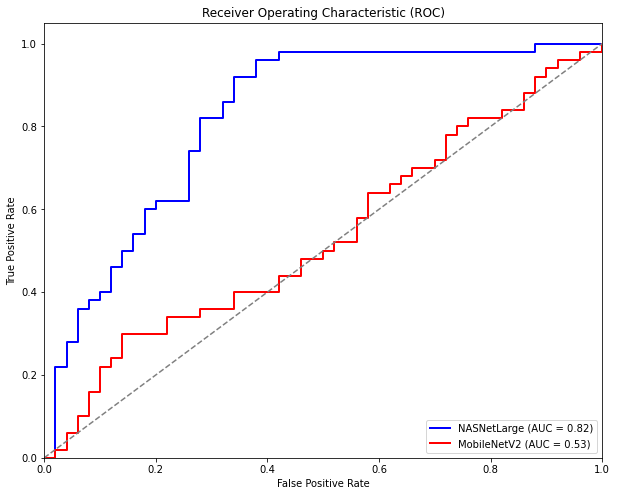

In [11]:
# plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_nas, tpr_nas, color='blue', lw=2, label=f'NASNetLarge (AUC = {roc_auc_nas:.2f})')
plt.plot(fpr_mobile, tpr_mobile, color='red', lw=2, label=f'MobileNetV2 (AUC = {roc_auc_mobile:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

NASNetLarge is the best model.